# ДЗ 1:

### Дизайн теста
1) Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

2) Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре) (0.5 балла)

3) На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность (1.5 балла)

4) Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test (1 балл)

### A/B тест
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

Еще 1 балл можно получить за хорошее и подробное объяснение каждого шага 

In [1]:
import os
import hashlib
from base64 import b64encode
from typing import Union

import numpy as np
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from tweedie.tweedie_dist import tweedie_gen

In [2]:
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')

In [3]:
pd.concat([interactions.head(3), interactions.tail(3)])

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


In [4]:
pd.concat([users.head(3), users.tail(3)])

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,1047345,age_45_54,income_40_60,Ж,0
840194,251008,NaN,NaN,NaN,0
840195,590706,NaN,NaN,Ж,0
840196,166555,age_65_inf,income_20_40,Ж,0


In [5]:
pd.concat([items.head(1), items.tail(1)])

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
15962,3206,series,Гоша,NaN,2019.0,комедии,Россия,0.0,16.0,NaN,Михаил Миронов,"Мкртыч Арзуманян, Виктория Рунцова","Добродушный Гоша не может выйти из дома, чтобы...","Гоша, 2019, Россия"


In [6]:
print(
    " === Кол-во уникальных users:\n"
    f" 1) у которых есть взаимодействия: {interactions['user_id'].nunique():_}\n"
    f" 2) которые есть в датасете для users: {users['user_id'].nunique():_}\n"
    " === Кол-во уникальных items:\n"
    f" 1) с которыми было взаимодействие: {interactions['item_id'].nunique():_}\n"
    f" 2) которые есть в датасете для items: {items['item_id'].nunique():_}"
)

 === Кол-во уникальных users:
 1) у которых есть взаимодействия: 962_179
 2) которые есть в датасете для users: 840_197
 === Кол-во уникальных items:
 1) с которыми было взаимодействие: 15_706
 2) которые есть в датасете для items: 15_963


# Дизайн теста

### 1. Из interactions взять данные за 2 последние недели (2021-08-09 по 2021-08-22)

In [7]:
interactions["last_watch_dt"] = pd.to_datetime(interactions["last_watch_dt"])

week2 = interactions[
    (interactions["last_watch_dt"] >= "2021-08-09")
    & (interactions["last_watch_dt"] <= "2021-08-22")
]

week2["last_watch_dt"].min(), week2["last_watch_dt"].max()

(Timestamp('2021-08-09 00:00:00'), Timestamp('2021-08-22 00:00:00'))

In [8]:
print(
    " === Кол-во уникальных users:\n"
    f" 1) у которых есть взаимодействия: {week2['user_id'].nunique():_}\n"
    " === Кол-во уникальных items:\n"
    f" 1) с которыми было взаимодействие: {week2['item_id'].nunique():_}\n"
)

 === Кол-во уникальных users:
 1) у которых есть взаимодействия: 266_081
 === Кол-во уникальных items:
 1) с которыми было взаимодействие: 8_406



In [9]:
print(week2.shape)
week2.drop_duplicates(inplace=True)
print(week2.shape)

(827089, 5)
(827089, 5)


/var/folders/9p/k5cfwtns6lgd7w8zs7srrj380000gn/T/ipykernel_90025/789820189.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  week2.drop_duplicates(inplace=True)


In [10]:
# Нам не важно сколько item'ов юзер просмотрел, нам важен `total_dur` => сгруппируем по юзерам
week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})
print(week2.shape)
week2.head()

(266081, 2)


/var/folders/9p/k5cfwtns6lgd7w8zs7srrj380000gn/T/ipykernel_90025/309705100.py:2: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})


,user_id,total_dur
0,1,21172
1,3,64654
2,9,108
3,12,5929
4,14,10324


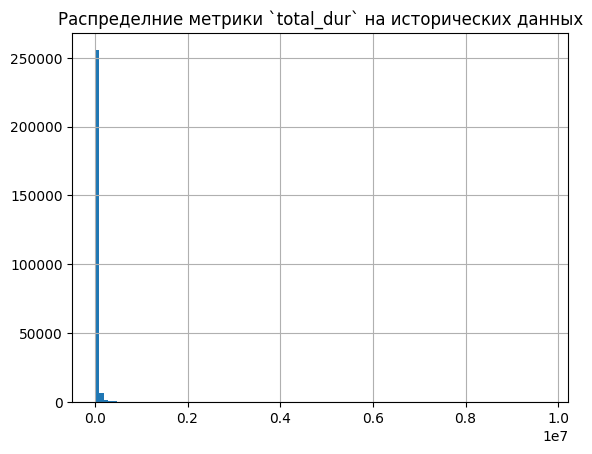

In [11]:
week2["total_dur"].hist(bins=100)
plt.title('Распределние метрики `total_dur` на исторических данных');

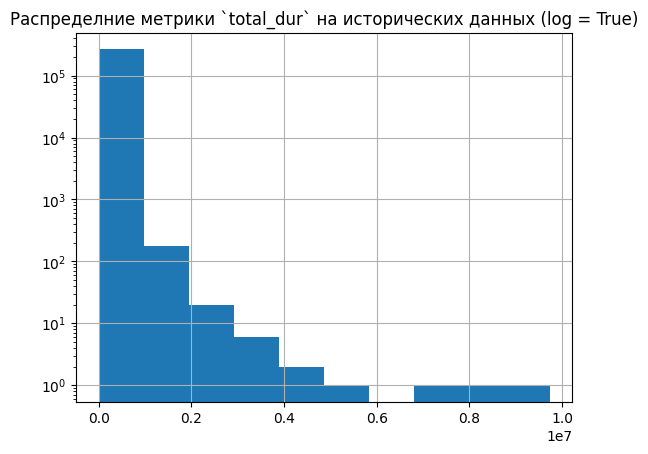

In [12]:
week2["total_dur"].hist(log=True)
plt.title('Распределние метрики `total_dur` на исторических данных (log = True)');

**Распределение метрики не является нормальным** => не можем применять t-test

**Посмотрим принимает ли метрика `total_dur` нули**

In [13]:
week2['total_dur'].describe()

count    2.660810e+05
mean     2.140820e+04
std      7.404068e+04
min      1.000000e+00
25%      8.800000e+02
50%      5.739000e+03
75%      1.830700e+04
max      9.731801e+06
Name: total_dur, dtype: float64

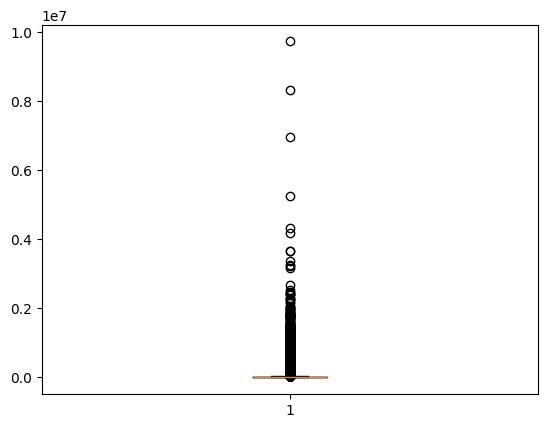

In [14]:
plt.boxplot(week2['total_dur'].values);

**Присутствует высокая дисперсия и имеются выбросы** => нужно от них избавиться

**`total_dur` не принимает значения ноль** => не беспокоимся за добавление эффекта, но хорошы бы добавлять эффект с учетом особенностей распределения метрики и его "физического смысла". 

**Так как метрика `total_dur` вряд ли сможет повыситься входе АБ-теста у пользователей в группе Б почти у всех**, иначе говоря, среднее время просмотра изменится у части пользователей в группе Б, то для оценки мощности следует добавлять эффект с учетом этого. **Тут на помощь приходит tweede-распределение**, которые добавит эффект только части пользователей.

Удаляем выбросы:

In [15]:
print(week2.shape)
# Так как `toral_dur` не может быть меньше нулю, можно `total_dur` ограничить только справа
# Зафиксируем максимальный `total_dur`, чтобы использовать так же обработать данные при расчете значений на AB-тесте 
MAX_TOTAL_DUR = week2['total_dur'].std() * 3
week2_prep = week2[(week2['total_dur'] < MAX_TOTAL_DUR)]
print(week2_prep.shape)

(266081, 2)
(262794, 2)


In [16]:
MAX_TOTAL_DUR

222122.02800964026

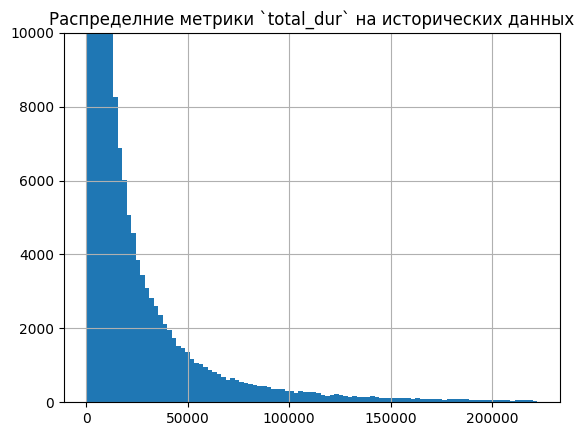

In [17]:
week2_prep["total_dur"].hist(bins=100)
plt.ylim([0, 10000])
plt.title('Распределние метрики `total_dur` на исторических данных');

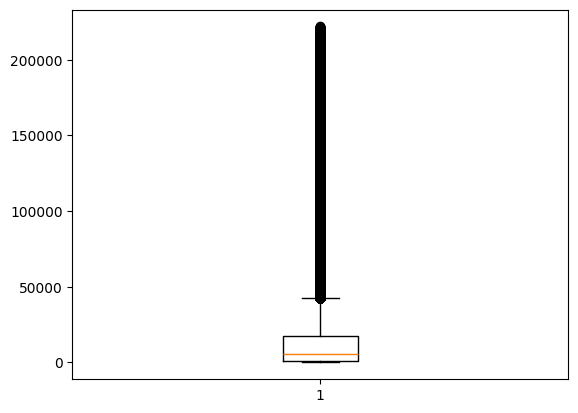

In [18]:
plt.boxplot(week2_prep['total_dur'].values);

In [19]:
week2_prep['total_dur'].describe()

count    262794.000000
mean      15843.013048
std       27843.529589
min           1.000000
25%         866.000000
50%        5602.000000
75%       17463.750000
max      222029.000000
Name: total_dur, dtype: float64

**Удалали выбросы** => можно дизайнить эксперимет

### 2. Посчитайте на этих данных корректность на бутстрепе и сравните ее с результатами за 1 неделю (посчитано на семинаре)

In [20]:
def salt_generator() -> str:
    """
    Generates a random salt value.

    Returns:
        str: The base64 encoded salt value as a string.
    """
    salt = os.urandom(8)
    return b64encode(salt).decode('ascii')


def groups_splitter(df: pd.DataFrame, columns: list[str], user_salt: str = None) -> pd.DataFrame:
    """
    Splits the data into two groups based on the salt value.

    Parameters:
        df (pd.DataFrame): The dataframe to split.
        columns (list[str]): The columns to split on.
        salt (str): The salt value to use for the split.
    """
    if user_salt is None:
        salt = salt_generator()
    else:
        salt = user_salt

    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()


def get_bootstrap_array(arr: Union[pd.Series, np.ndarray]) -> np.ndarray:
    """
    Generates a bootstrap array by randomly sampling elements from the input array with replacement.

    Parameters:
        arr (Union[pd.Series, np.ndarray]): The input array to generate the bootstrap array from.

    Returns:
        np.ndarray: The bootstrap array generated from the input array.
    """
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr: Union[pd.Series, np.ndarray], size: int) -> np.ndarray:
    """
    Calculate the bootstrap mean of an array.

    Parameters:
        arr (Union[pd.Series, np.ndarray]): Input array.
        size (int): Number of iterations.

    Returns:
        np.ndarray: Array of bootstrap means.
    """
    result = np.empty(size)
    for idx in range(size):
        result[idx] = np.mean(get_bootstrap_array(arr))
    return result


def get_p_value(dist):
    """
    Calculate the p-value of a distances.

    Parameters:
        dist: Input distances.

    Returns:
        float: P-value of the distances.
    """
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue


def generate_tweedie(mu, shape, p=1.5, phi=25):
    """
    Generate a tweedie distribution.

    Parameters:
        mu: Mean parameter of the distribution.
        shape: Shape parameter of the distribution.
        p (float): Power parameter (default=1.5).
        phi (float): Dispersion parameter (default=25).

    Returns:
        np.ndarray: Array of random variates from the tweedie distribution.
    """
    tw = tweedie_gen()
    return tw(p=p, mu=mu, phi=phi).rvs(shape)

In [21]:
ITER_BOOTSTRAP = 1000 # common cycle
NUMBER_GENERATE_PSEUDO_SAMPLES = 1000  # number of pseudo samples for bootstrap
ALPHA = 0.05

In [51]:
correctness = []
diff_values = []

for _ in tqdm(range(ITER_BOOTSTRAP)):
    # split on two groups
    new_df = groups_splitter(
        df=week2_prep.copy(),
        columns=["user_id", "total_dur", "group"],
        user_salt=salt_generator() # create salt
    ).drop_duplicates()

    # obtain the values of the studied quantity by group
    vec_a = new_df[new_df["group"] == "A"]["total_dur"]
    vec_b = new_df[new_df["group"] == "B"]["total_dur"]
    
    # get values on bootstrap
    sample_a_mean = calc_bootstrap_mean(arr=vec_a, size=NUMBER_GENERATE_PSEUDO_SAMPLES)
    sample_b_mean = calc_bootstrap_mean(arr=vec_b, size=NUMBER_GENERATE_PSEUDO_SAMPLES)
    diff_values.append(sample_a_mean - sample_b_mean)

    # calculate the 95% confidence interval for the difference in means
    left_side, right_side = np.percentile(
        sample_a_mean - sample_b_mean, 
        [100 * ALPHA / 2., 100 * (1 - ALPHA / 2.)]
    )

    correctness.append(not left_side <= 0 <= right_side)

significance = np.mean(correctness)
print(f"significance: {significance * 100:0.3}%")


100%|██████████| 1000/1000 [1:36:52<00:00,  5.81s/it]

significance: 5.6%


Тест на 1 неделю (см. семинар) на корректность показал 5% => **тест на 2 недели показал схожий результат**

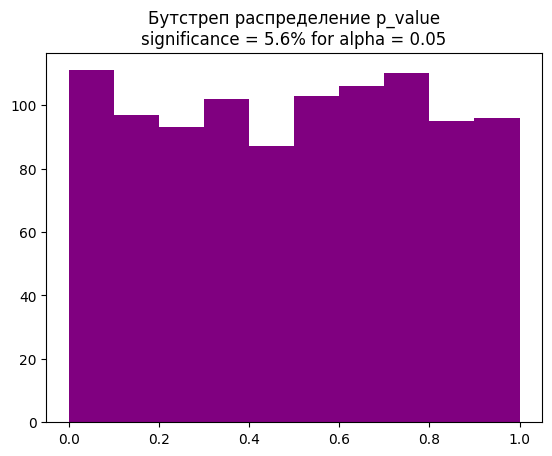

In [55]:
# get p-values
p_values = [get_p_value(dist) for dist in diff_values]

# Check distribution. Distribution p-value must be uniform!
plt.hist(p_values, bins=10, color='purple')
plt.title(f"Бутстреп распределение p_value\nsignificance = {significance*100:0.3}% for alpha = {ALPHA}");

Распределение напоминает нормальное.

Для большей уверенности применим критерий **Колмогорова-Смирнова** для проверки гипотезы, что p-values имеет равномерное распределение

In [56]:
stat, p_value = stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values неравномерное распределение')
else:
    print(f'p_value = {p_value} - p_values равномерное распределение')

p_value = 0.7097553870119024 - p_values равномерное распределение


**При этом распределение P-values является равномерным**

### 3. На двух неделях посчитайте мощность. Для этого нужно в одну из групп докинуть эффект. Докиньте эффект в 1%, 3% и 5% и сравните полученную мощность

In [25]:
EFFECTS = [0.01, 0.03, 0.05]

corrections = [[] for _ in range(len(EFFECTS))]
diff_values = [[] for _ in range(len(EFFECTS))]

for _ in tqdm(range(ITER_BOOTSTRAP)):
    # create salt
    salt = salt_generator()

    # split on two groups
    new_df = groups_splitter(
        df=week2_prep.copy(),
        columns=["user_id", "total_dur", "group"],
        user_salt=salt
    )

    # obtain the values of the studied quantity by group
    vec_a = new_df[new_df["group"] == "A"]["total_dur"]
    vec_b = new_df[new_df["group"] == "B"]["total_dur"]

    # add effect to metric for group B
    vecs_b = []
    mean_b = vec_b.mean()
    for effect in EFFECTS:
        vecs_b.append(
            vec_b + generate_tweedie(effect * mean_b, len(vec_b))
        ) 
    del vec_b

    # get values on bootstrap
    sample_a_mean = calc_bootstrap_mean(arr=vec_a, size=NUMBER_GENERATE_PSEUDO_SAMPLES)

    samples_b_mean = []
    for vec_b in vecs_b:
        samples_b_mean.append(
            calc_bootstrap_mean(arr=vec_b, size=NUMBER_GENERATE_PSEUDO_SAMPLES)
        )
    del vecs_b

    for idx, sample_b_mean in enumerate(samples_b_mean): 
        diff_values[idx].append(sample_a_mean - sample_b_mean)
    del samples_b_mean

    # calculate the 95% confidence interval for the difference in means
    for idx, diff_v in enumerate(diff_values): 
        left_side, right_side = np.percentile(
            diff_v[-1], 
            [100 * ALPHA / 2., 100 * (1 - ALPHA / 2.)]
        )
        corrections[idx].append(not left_side <= 0 <= right_side)

powers = {}
for idx, correct in enumerate(corrections):
    power = np.mean(correct)
    powers[f"effect_{EFFECTS[idx] * 100}%"] = [power]
    print(f" === Мощность бустрэпа при эффекте в группу Б в {EFFECTS[idx] * 100}% : {power * 100:0.3}%")

100%|██████████| 1000/1000 [2:58:48<00:00, 10.73s/it] 

 === Мощность бустрэпа при эффекте в группу Б в 1.0% : 33.8%
 === Мощность бустрэпа при эффекте в группу Б в 3.0% : 99.3%
 === Мощность бустрэпа при эффекте в группу Б в 5.0% : 1e+02%


In [26]:
result_power = pd.DataFrame(powers, index=["Мощность"])
powers = result_power.loc["Мощность"].values
result_power

,effect_1.0%,effect_3.0%,effect_5.0%
Мощность,0.338,0.993,1.0


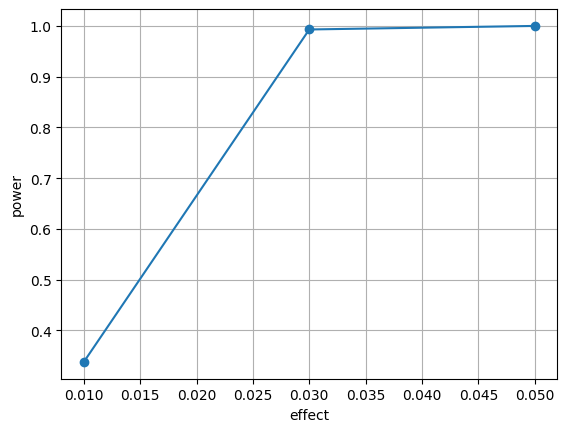

In [27]:
plt.plot(
    EFFECTS,
    powers,
    marker="o"
)
plt.xlabel("effect")
plt.ylabel("power")
plt.grid();

**Значения мощности для 3% и 5% имеют хорошие значения, которая нас могут удовлетворить**

### 4. Посчитайте MDE, который можно зафиксировать на 2х неделях. В качестве alpha и beta подставьте ваши вычисленные ошибки 1 и 2 рода. Учитывайте что у нас формула для MDE работает для t-test или z-test

In [28]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_num = metric_vec.mean(), metric_vec.std(), len(metric_vec)
    
    z_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta) * metric_std / np.sqrt(metric_num)
    
    return mde * 100 / metric_mean

Формула для расчета mde, которая была реазилована выше, работает только для t-test и z-test, но в наших расчетах для корректности и мощности использовался бустреп, поэтому следут её изменить.

Так как корректность была получена около 5% и нас удовлетворит мощность равная 0.8, то можно воспользоваться расчитынными мощностями из пункта выше, так как они были расчитаны для уровня значимости alpha = 0.05. Сделаем линейную апроксимацию между значениями эффекта 0.01 и 0.03, тем самым мы сможем найти эффект при мощности 0.8, который и будет являтся MDE (минимальный детектируемый эффект)

In [30]:
k = (powers[1] - powers[0]) / (EFFECTS[1] - EFFECTS[0])
b = powers[1] - EFFECTS[1] * k

power_needed = 0.8
mde = (power_needed - b) / k
print(f"MDE = {mde * 100:0.5}%")

MDE = 2.4107%


In [47]:
# для интереса рассмотрим mde посчитанный по формуле с семинара
get_mde(week2_prep["total_dur"], alpha=0.06, beta=0.2)

0.9333254083412641

# A/B тест

### Занулим для всех пользователей total_dur, у которых total_dur < 500

In [34]:
week2_ab = week2.copy()
week2_ab.loc[week2_ab["total_dur"] < 500, "total_dur"] = 0
pd.concat([week2_ab.head(), week2_ab.tail()])

,user_id,total_dur
0,1,21172
1,3,64654
2,9,0
3,12,5929
4,14,10324
266076,1097536,0
266077,1097540,0
266078,1097544,16478
266079,1097545,0
266080,1097549,0


### Разобем пользователей на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805'

In [35]:
salt = "kiontestmodel20210805"
ab_df = groups_splitter(df=week2_ab, columns=["user_id", "total_dur", "group"], user_salt="salt")
pd.concat([ab_df.head(), ab_df.tail()])

,user_id,total_dur,group
0,1,21172,B
1,3,64654,A
2,9,0,A
3,12,5929,A
4,14,10324,A
266076,1097536,0,A
266077,1097540,0,B
266078,1097544,16478,A
266079,1097545,0,B
266080,1097549,0,A


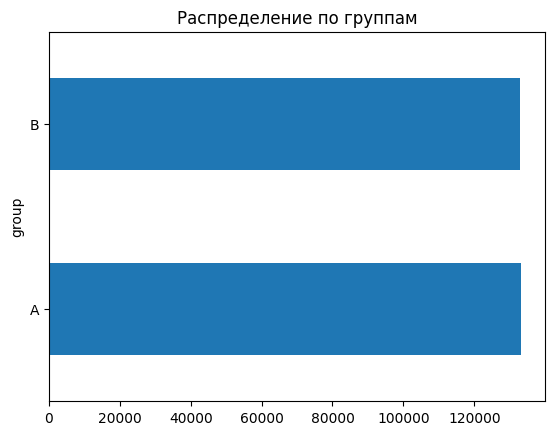

In [36]:
ab_df["group"].value_counts().plot.barh()
plt.title("Распределение по группам");

**Каждый пользователь был отнесен только к одной группе**

### ПРЕДПОЛОЖИМ, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением.

In [37]:
num_user_id_10_percent = int(ab_df[ab_df["group"] == "B"]["user_id"].nunique() * 0.1)
print(f"Количество пользователей в 10% от всех пользователей: {num_user_id_10_percent}")

# 1. Сортируем пользователей из группы Б по продолжительности просмотра в порядке убывания
# 2. Берем user_id из топ 10% всех пользователей
uses_id_from_10_percent = (
    ab_df[ab_df["group"] == "B"].sort_values("total_dur", ascending=False)["user_id"]
    .iloc[: num_user_id_10_percent].tolist()
)

assert len(uses_id_from_10_percent) == num_user_id_10_percent

ab_df["total_dur_ab"] = ab_df["total_dur"].copy()
ab_df.loc[ab_df["user_id"].isin(uses_id_from_10_percent), "total_dur_ab"] *= 1.025

pd.concat([ab_df.head(), ab_df.head()])

Количество пользователей в 10% от всех пользователей: 13282


/var/folders/9p/k5cfwtns6lgd7w8zs7srrj380000gn/T/ipykernel_90025/3394413470.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 48441.5    89649.575  48890.45  ... 248961.225 253760.275  63301.95 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  ab_df.loc[ab_df["user_id"].isin(uses_id_from_10_percent), "total_dur_ab"] *= 1.025


,user_id,total_dur,group,total_dur_ab
0,1,21172,B,21172.0
1,3,64654,A,64654.0
2,9,0,A,0.0
3,12,5929,A,5929.0
4,14,10324,A,10324.0
0,1,21172,B,21172.0
1,3,64654,A,64654.0
2,9,0,A,0.0
3,12,5929,A,5929.0
4,14,10324,A,10324.0


Проверим, как изменилась метрика для 10 случайных пользователей из группы B и 10 %:

In [38]:
ab_df[
    ab_df["user_id"].isin(np.random.choice(uses_id_from_10_percent, size=10, replace=False))
]

,user_id,total_dur,group,total_dur_ab
25721,107421,60311,B,61818.775
34019,141693,170006,B,174256.150
38858,161674,72047,B,73848.175
93679,388066,656550,B,672963.750
119118,493076,82140,B,84193.500
152648,631330,58775,B,60244.375
156759,648242,75256,B,77137.400
217546,897035,52244,B,53550.100
220784,910003,50112,B,51364.800
240167,990494,112880,B,115702.000


**средний `total_dur` в группах до AB:**

In [39]:
ab_df.groupby("group", as_index=False)["total_dur"].agg("mean")

,group,total_dur
0,A,21483.851851
1,B,21286.489147


### Посчитайте результат такого теста и сделайте выводы

**Для подведения результатов AB-теста применим бутстрем**

**НЕ ЗАБЫВАЕМ, что для дезайна АБ удалялись выбросы**

In [40]:
ab_df["total_dur_ab"].describe()

count    2.660810e+05
mean     2.155322e+04
std      7.491525e+04
min      0.000000e+00
25%      8.800000e+02
50%      5.739000e+03
75%      1.830700e+04
max      9.975096e+06
Name: total_dur_ab, dtype: float64

In [41]:
ab_df = ab_df[(ab_df['total_dur_ab'] < MAX_TOTAL_DUR)]

**средний `total_dur` в группах после AB:**

In [42]:
ab_df.groupby("group", as_index=False)["total_dur_ab"].agg("mean")

,group,total_dur_ab
0,A,15784.567700
1,B,15961.209207


In [43]:
# 1. Получаем группы А и Б
group_a = ab_df[ab_df["group"] == "A"]["total_dur_ab"]
group_b = ab_df[ab_df["group"] == "B"]["total_dur_ab"]

# 2. 1000 раз генерируем подвыборки того же размера, что исходные группы контроля и эксперимента
# 3. Считаем среднее для каждой сгенерированной подвыборки
# get values on bootstrap
sample_a_mean = calc_bootstrap_mean(arr=group_a, size=1000)
sample_b_mean = calc_bootstrap_mean(arr=group_b, size=1000)

# 4. Вычисляем разность на каждой из сгенерированных пар выборок
differences = sample_a_mean - sample_b_mean

# 5. Cтроим доверительный интервал для разностей из п.4 с уровнем значимости alpha = 0.5
# calculate the 95% confidence interval for the difference in means
ALPHA = 0.05
left_side, right_side = np.percentile(
    differences, 
    [
        100 * ALPHA / 2., 
        100 * (1 - ALPHA / 2.)
    ]
)

# 6. Смотрим доверительный интервал содержит ноль или нет
include_zero = left_side <= 0 <= right_side
p_value = get_p_value(dist=differences)

print("ВЫВОДЫ:\n")
print(" ====================== ")
print(f"При уровне значимости = {ALPHA} / при уровне доверия = {1 - ALPHA}:\n")
if include_zero:
    print(
        f"H0 принимается, то есть среднии значения группы А и Б не имеют статистически значимых отличий\n"
        f" - P-value = {p_value} > {ALPHA}\n"
    )
    print()
else:
    print(
        f"H0 отвергается, то есть среднии значения группы А и Б имеют статистически значимые отличия\n"
        f" - P-value = {p_value} < {ALPHA}\n"
    )

print(
    f" - Границы доверительного интервала: левая = {left_side} - правая = {right_side}"
)

ВЫВОДЫ:

При уровне значимости = 0.05 / при уровне доверия = 0.95:

H0 принимается, то есть среднии значения группы А и Б не имеют статистически значимых отличий
 - P-value = 0.084 > 0.05


 - Границы доверительного интервала: левая = -386.61926639570976 - правая = 24.89297608454


**Эффект, который был достигнут:**

In [44]:
mean_by_group = ab_df.groupby("group", as_index=False)["total_dur_ab"].agg("mean")
effect = (
    mean_by_group[mean_by_group["group"] == "B"]["total_dur_ab"].iloc[0] 
    / mean_by_group[mean_by_group["group"] == "A"]["total_dur_ab"].iloc[0]
)
print(f"Достигнутый эффект: {(effect - 1) * 100:0.3}%")

Достигнутый эффект: 1.12%


Такой эффект на АБ-тесте мы бы не смогли отловить, так как MDE, посчитанный выше составляет 2.4107%

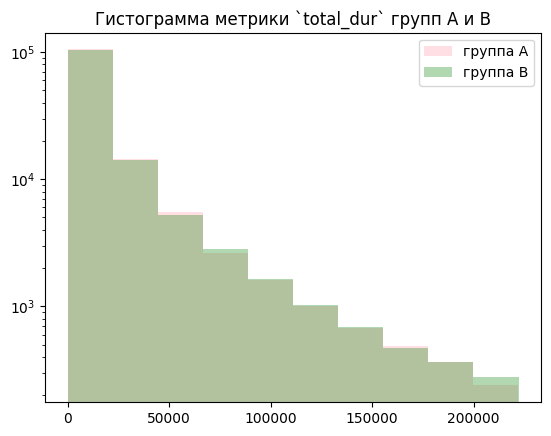

In [45]:
plt.hist(group_a, alpha=0.5, color="pink", label="группа A", log=True)
plt.hist(group_b, alpha=0.3, color="green", label="группа B", log=True)
plt.legend()
plt.title("Гистограмма метрики `total_dur` групп А и B");

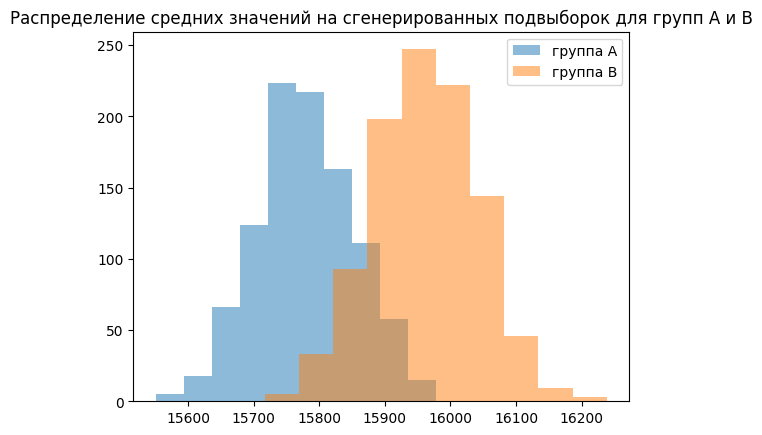

In [46]:
plt.hist(sample_a_mean, alpha=0.5, label="группа A");
plt.hist(sample_b_mean, alpha=0.5, label="группа B")
plt.legend()
plt.title("Распределение средних значений на сгенерированных подвыборок для групп А и B");